In [1]:
!pip install easyocr
!pip install imutils

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import easyocr
import imutils

<h1>1. Reading Image, GrayScaling and Blur <h1>

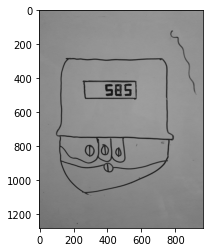

In [2]:
img = cv2.imread("image16.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

<h1>2. Applying filter and finding edges for localization<h1>

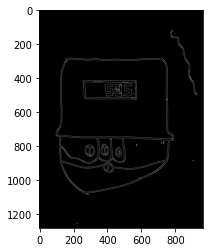

In [3]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise Reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged,cv2.COLOR_BGR2RGB))

In [4]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]

In [5]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break
        

In [6]:
location

array([[[255, 418]],

       [[271, 522]],

       [[570, 523]],

       [[568, 416]]], dtype=int32)

In [7]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0, 255, -1)
new_image = cv2.bitwise_and(img, img, mask = mask)

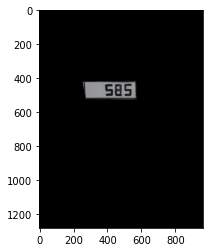

In [8]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [9]:
(x,y) = np.where(mask == 255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

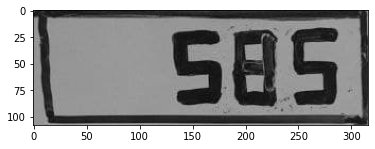

In [10]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [11]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[120, 4], [302, 4], [302, 104], [120, 104]], '5E5', 0.22533126175403595)]

In [12]:
def patch(value, prob):
    patchdict = {'J':'9', 'E':'8', 'g':'9', 'G':'8'}
    units = list(value)
    for i in range(len(list(units))):
        if (units[i] in patchdict.keys()) and prob < 0.4:
            units[i] = patchdict[units[i]]
    finalunits = ""
    finalunits = int(finalunits.join(units))
    return finalunits
    

In [13]:
import smtplib, ssl

def send_email(base, record):
    sender_email = "electricitybillnotifier@gmail.com"
    receiver_email = "demesaikiran1729@gmail.com"
    password = "Electricity@jntuh"
    message = "You have used "+ str(record - base) + " units till now, Decrese your power consumption"
    
    context = ssl.create_default_context()
    with smtplib.SMTP_SSL("smtp.gmail.com", 465, context = context) as server:
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message)
    
        

In [14]:
value = result[0][1]
probability = result[0][-1]
base = 500

unitvalue = patch(value, probability)

In [15]:
if unitvalue - base >= 80:
    send_email(base, unitvalue)